![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)


NOTE: for the most up to date version of this notebook, please copy from

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ntAL_zI68xfvZ4uCSAF6XT27g0U4mZbW#scrollTo=VHS_o3KGIyXm)




## **Training YOLOv3 object detection on a custom dataset**

PyTorch Edition! Thanks to [Ultralytics](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) for making this simpler.

### **Overview**

This notebook walks through how to train a YOLOv3 object detection model on your own dataset using Roboflow and Colab.

In this specific example, we'll training an object detection model to recognize chess pieces in images. **To adapt this example to your own dataset, you only need to change one line of code in this notebook.**

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full).

### **Our Model**

We'll be training a YOLOv3 (You Only Look Once) model. This specific model is a one-shot learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant, viewing up to 60 frames per second in predicting against video feeds.

The GitHub repo containing the majority of the code we'll use is available [here](https://github.com/roboflow-ai/yolov3).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll leverage the `detect.py --weights weights/last.pt` script to produce predictions. Arguments are specified below.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)








In [1]:
import os
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [2]:
!git clone https://github.com/roboflow-ai/yolov3  # clone

Cloning into 'yolov3'...
remote: Enumerating objects: 8443, done.
remote: Total 8443 (delta 0), reused 0 (delta 0), pack-reused 8443
Receiving objects: 100% (8443/8443), 6.89 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (5825/5825), done.


## Get Data from Roboflow

Create an export from Roboflow. **Select "YOLO Darknet" as the export type.**

Our labels will be formatted to our model's architecture.

In [7]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/Chess+Pieces.v24-416x416_aug.darknet.zip
!unzip -q 'Chess+Pieces.v24-416x416_aug.darknet.zip'

## Organize data and labels for Ultralytics YOLOv3 Implementation

Ultalytics's implemention of YOLOv3 calls for [a specific file management](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) where our images are in a folder called `images` and corresponding labels in a folder called `labels`. The image and label names must match identically. Fortunately, our files are named appropriately from Roboflow.

We need to reorganize the folder structure slightly.

In [4]:
%cd train

[Errno 2] No such file or directory: 'train'
/content


In [5]:
%ls

Chess+Pieces.v24-416x416_aug.darknet.zip  sample_data/  yolov3/


In [ ]:
%mkdir labels
%mkdir images

In [ ]:
%mv *.jpg ./images/
%mv *.txt ./labels/

mv: cannot stat '*.jpg': No such file or directory
mv: cannot stat '*.txt': No such file or directory


In [ ]:
%cd images

/content/images


In [ ]:
# create Ultralytics specific text file of training images
file = open("train_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "train_images_roboflow.txt":
        pass
      else:
        file.write("../train/images/" + filename + "\n")
file.close()

In [ ]:
%cat train_images_roboflow.txt

In [ ]:
%cd ../../valid

[Errno 2] No such file or directory: '../../valid'
/content/images


In [ ]:
%mkdir labels
%mkdir images

In [ ]:
%mv *.jpg ./images/
%mv *.txt ./labels/

mv: cannot stat '*.jpg': No such file or directory


In [ ]:
%cd images

/content/images/images


In [ ]:
# create Ultralytics specific text file of validation images
file = open("valid_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "valid_images_roboflow.txt":
        pass
      else:
        file.write("../valid/images/" + filename + "\n")
file.close()

In [ ]:
%cat valid_images_roboflow.txt

## Set up model config

We should configure our model for training.

This requires editing the `roboflow.data` file, which tells our model where to find our data, our numbers of classes, and our class label names.

Our paths for our labels and images are correct.

But we need to update our class names. That's handled below..




In [ ]:
%cd ../../yolov3/data

/content/yolov3/data


In [ ]:
# display class labels imported from Roboflow
%cat ../../train/_darknet.labels

bishop
black-bishop
black-king
black-knight
black-pawn
black-queen
black-rook
white-bishop
white-king
white-knight
white-pawn
white-queen
white-rook

In [ ]:
# convert .labels to .names for Ultralytics specification
%cat ../../train/_darknet.labels > ../../train/roboflow_data.names

In [ ]:
def get_num_classes(labels_file_path):
    classes = 0
    with open(labels_file_path, 'r') as f:
      for line in f:
        classes += 1
    return classes

In [ ]:
# update the roboflow.data file with correct number of classes
import re

num_classes = get_num_classes("../../train/_darknet.labels")
with open("roboflow.data") as f:
    s = f.read()
with open("roboflow.data", 'w') as f:
    
    # Set number of classes num_classes.
    s = re.sub('classes=[0-9]+',
               'classes={}'.format(num_classes), s)
    f.write(s)

In [ ]:
# display updated number of classes
%cat roboflow.data

classes=13
train=../train/images/train_images_roboflow.txt
valid=../valid/images/valid_images_roboflow.txt
names=../train/roboflow_data.names


## Training our model

Once we have our data prepped, we'll train our model using the train script.

By default, this script trains for 300 epochs.

In [ ]:
%cd ../

/content/yolov3


In [ ]:
!python3 train.py --data data/roboflow.data --epochs 300

Namespace(accumulate=4, adam=False, batch_size=16, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='data/roboflow.data', device='', epochs=300, evolve=False, img_size=[416], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, var=None, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2487      0 --:--:-- --:--:-- --:--:--  2472
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  240M  100  240M    0     0   166M      0  0:00:01  0:00:01 --:--:--  299M
Caching labels (6

## Display training performance

We'll use a default provided script to display image results. **For example:**

![example results](https://user-images.githubusercontent.com/26833433/63258271-fe9d5300-c27b-11e9-9a15-95038daf4438.png)

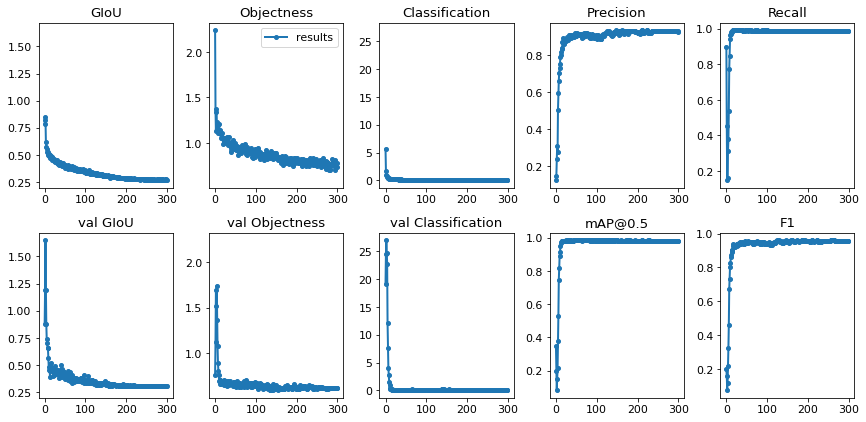

In [ ]:
from utils import utils; utils.plot_results()

## Conduct inference and display results



### Conduct inference

The below script has a few key arguments we're using:
- **Weights**: we're specifying the weights to use for our model should be those that we most recently used in training
- **Source**: we're specifying the source images we want to use for our predictions
- **Names**: we're defining the names we want to use. Here, we're referencing `roboflow_data.names`, which we created from our Roboflow `_darknet.labels`italicized text above.

In [ ]:
!python3 detect.py --weights weights/last.pt --source=../test --names=../train/roboflow_data.names

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', total_memory=16160MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
image 1/29 ../test/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg: 416x416 1 white-bishops, Done. (0.027s)
image 2/

### Displaying our results

Ultralytics generates predictions which include the labels and bounding boxes "printed" directly on top of our images. They're saved in our `output` directory within the YOLOv3 repo we cloned above.

In [ ]:
# import libraries for display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from glob import glob
import random
import PIL

IMG_0170_JPG.rf.480e7164cb4727f6654402882f0ce942.jpg


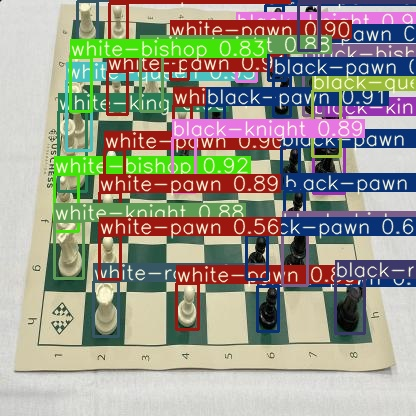

In [ ]:
# plot just one random image prediction
filename = random.choice(os.listdir('./output'))
print(filename)
Image('./output/' + filename)

In [ ]:
# grab all images from our output directory
images = [ PIL.Image.open(f) for f in glob('./output/*') ]

In [ ]:
# convert images to numPy
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

In [ ]:
# create array of numPy images
np_images = [ img2array(im) for im in images ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [ ]:
# plot ALL results in test directory (NOTE: adjust figsize as you please)
for img in np_images:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

## Save Our Weights

We can save the weights of our model to use them for inference in the future, or pick up training where we left off. 

We can first save them locally. We'll connect our Google Drive, and save them there.


In [ ]:
# save locally
from google.colab import files
files.download('./weights/last.pt')

In [ ]:
# connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%pwd

In [ ]:
# create a copy of the weights file with a datetime 
# and move that file to your own Drive
%cp ./weights/last.pt ./weights/last_copy.pt
%mv ./weights/last_copy.pt /content/gdrive/My\ Drive